#### This models what occurs in the systems, from a starting point of the drug being injected subcutaneously and how it behaves from there — the AD part of ADME.

# Imports and useful functions

In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Define parameters

In [87]:
# Define PK parameters
k_ABS = 1  # Absorption rate constant
k_CP = 0.1  # Rate constant from central to peripheral compartment
k_PC = 0.1  # Rate constant from peripheral to central compartment
k_Celim = 0.001  # Elimination rate constant (30 day half-life)
k_CT = 0.01  # Rate constant for tumor homing
k_TC = 0.01  # Rate constant for leaving the tumor compartment
k_CL = 0.001  # Rate constant for accumulation in the liver
k_TMEelim = 0.00001  # TME effects reducing persistence in the tumor

V_CENTRAL = 3.0  # Volume of central compartment [Liters], plasma in blood
V_TUMOR = 0.1  # Volume of tumor compartment [Liters], average size of a large tumor (100 cm^3)
dose = 200  # Initial dose [10^6 cells]
AVOGADRO = 6.022e23  # Avogadro's number [molecules/mol]

In [88]:
parameter_sweep = {
    'k_ABS': 1, # If IV injection, dose is immediately available in the central compartment.
    'k_CP': np.logspace(-6, -1, 6), # [1/min] Wide range of values
    'k_PC': np.logspace(-6, -1, 6), # [1/min]
    'k_Celim': np.logspace(-6, -3, 6), # [1/min]
    'k_CT': np.logspace(-6, -1, 6), # [1/min] Depending on efficacy of design
    'k_TC': np.logspace(-3, -1, 6), # [1/min] Depends on tumor's ability to retain drug
    'k_CL': np.logspace(-6, -1, 6), # [1/min] Cachectic patients might suffer from higher levels of trafficking into the liver
    'k_TMEelim': 0.05, # [1/min] TME effects reducing persistence in the tumor
    'dose': [20, 70, 140, 200, 300, 450], # [10^6 of cells, determined for a 70 kg individual]
}

## Define the model

In [89]:
# Define the multi-compartment model with biodistribution and TME effects
def pk_model(y, t, k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim):
    dAdt = -k_ABS * y[0]  # Dosing compartment
    dCdt = (k_ABS * y[0] / V_CENTRAL) - (k_CP + k_CT + k_CL + k_Celim) * y[1] \
           + k_PC * y[2] + k_TC * y[3]  # Central compartment
    dPdt = k_CP * y[1] - k_PC * y[2]  # Peripheral compartment
    dTdt = k_CT * y[1] - (k_TC + k_TMEelim) * (y[3])  # Tumor compartment
    dLiverdt = k_CL * y[1]  # Liver compartment (accumulation only)
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt]

## Simulation and solving the ODE

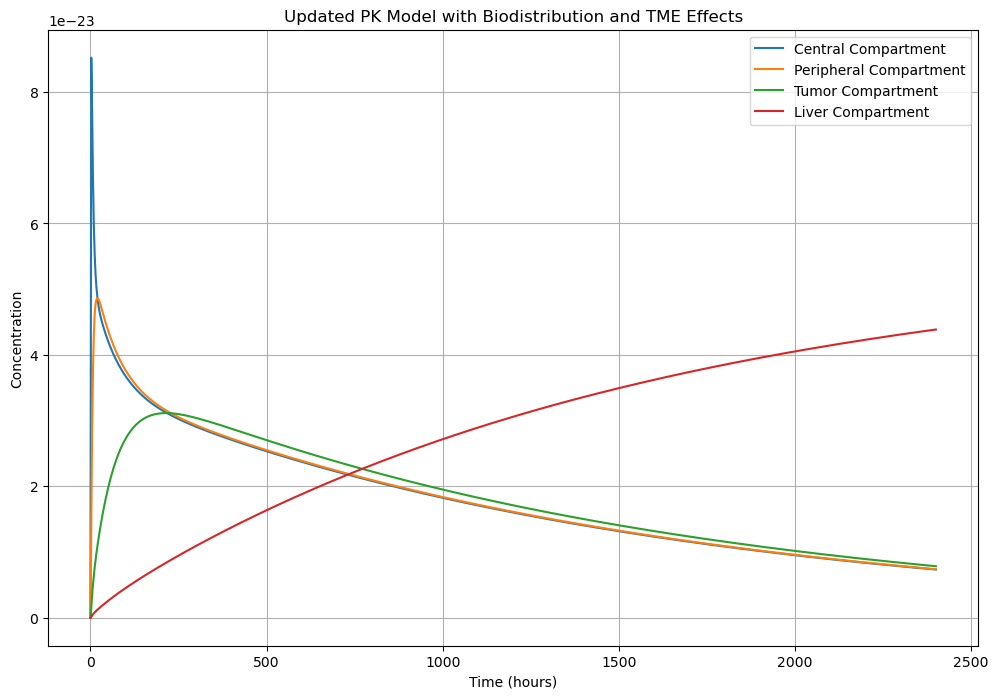

In [92]:
# Time points for simulation
t = np.linspace(0, 2400, 1000)  # Simulate over 48 hours with fine resolution

# Initial conditions: [Dosing Compartment [mol], Central Compartment [mol], Peripheral Compartment [mol], Tumor Compartment [mol], Liver Compartment [mol]]
y0_updated = [dose/AVOGADRO, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

# Solve ODE for the updated model
solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

# Plot results for all compartments
plt.figure(figsize=(12, 8))
plt.plot(t, solution_updated[:, 1], label='Central Compartment')
plt.plot(t, solution_updated[:, 2], label='Peripheral Compartment')
plt.plot(t, solution_updated[:, 3], label='Tumor Compartment')
plt.plot(t, solution_updated[:, 4], label='Liver Compartment')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Updated PK Model with Biodistribution and TME Effects')
plt.legend()
plt.grid(True)
plt.show()

## Sensitivity analysis
### Run the simulation over a parameter sweep

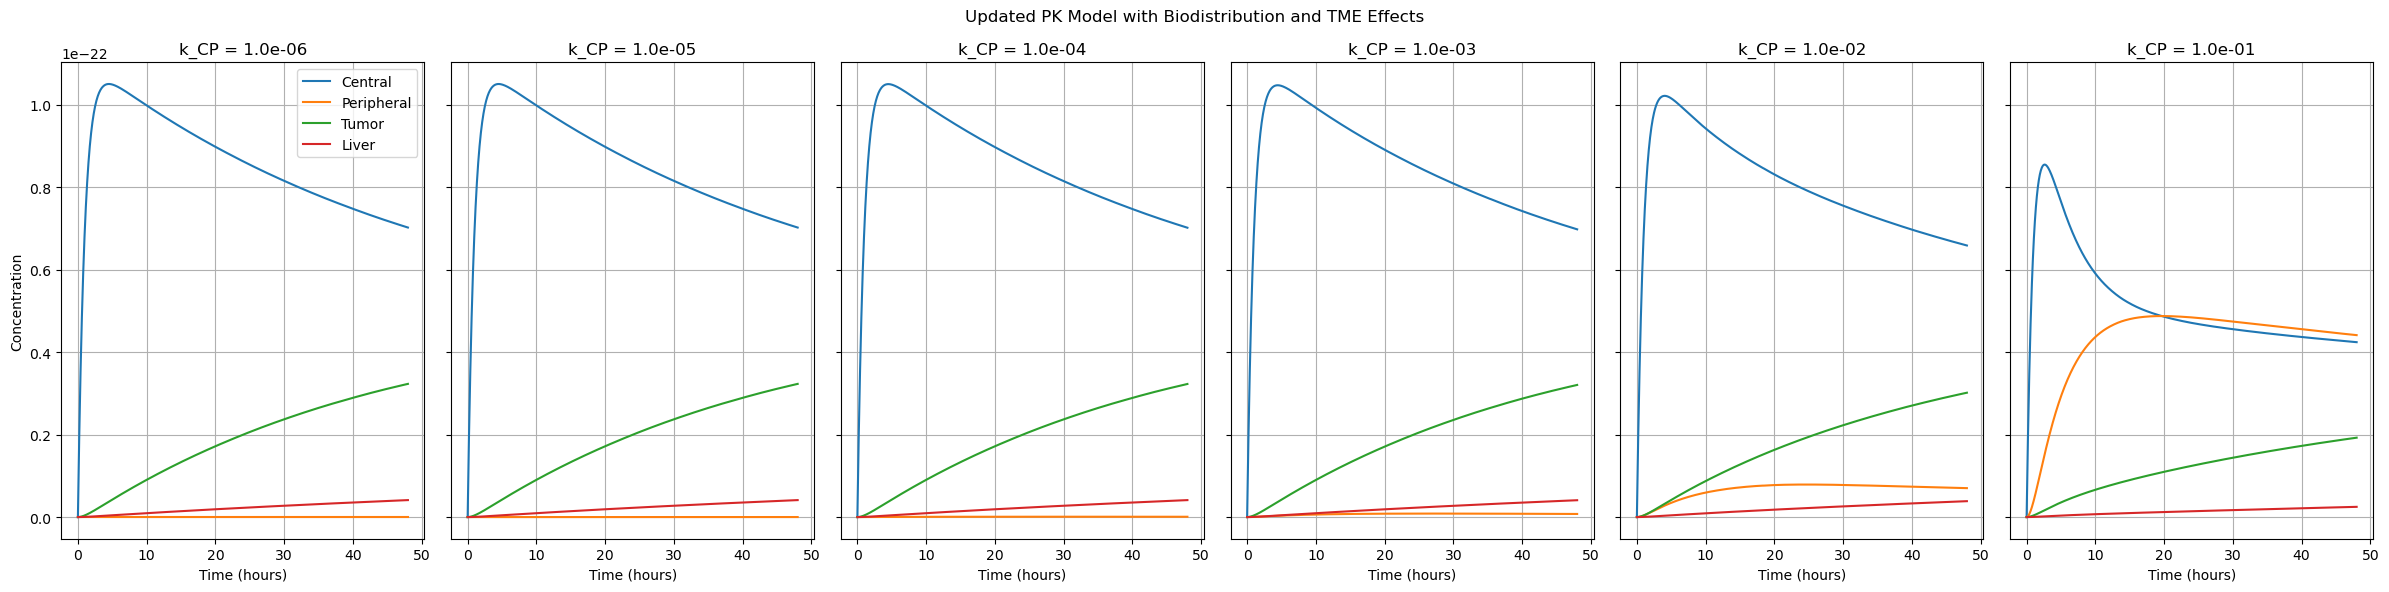

In [91]:
# for k_a specifically
# Time points for simulation
t = np.linspace(0, 48, 1000)  # Simulate over 48 hours with fine resolution

# Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
# Tumor Compartment, Liver Compartment, Lung Compartment]
y0_updated = [dose/AVOGADRO, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

num_sweeps = len(parameter_sweep['k_CP'])
fig, axes = plt.subplots(1, num_sweeps, figsize=(num_sweeps * 4, 6), sharey=True)

for i, k_CP in enumerate(parameter_sweep['k_CP']):
    # Solve ODE for the updated model
    solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

    ax = axes[i] if num_sweeps > 1 else axes
    ax.plot(t, solution_updated[:, 1], label='Central')
    ax.plot(t, solution_updated[:, 2], label='Peripheral')
    ax.plot(t, solution_updated[:, 3], label='Tumor')
    ax.plot(t, solution_updated[:, 4], label='Liver')

    ax.set_xlabel('Time (hours)')
    ax.set_title(f'k_CP = {k_CP:.1e}')
    ax.grid(True)

axes[0].set_ylabel('Concentration')
axes[0].legend()

plt.suptitle('Updated PK Model with Biodistribution and TME Effects')
plt.tight_layout()
plt.show()

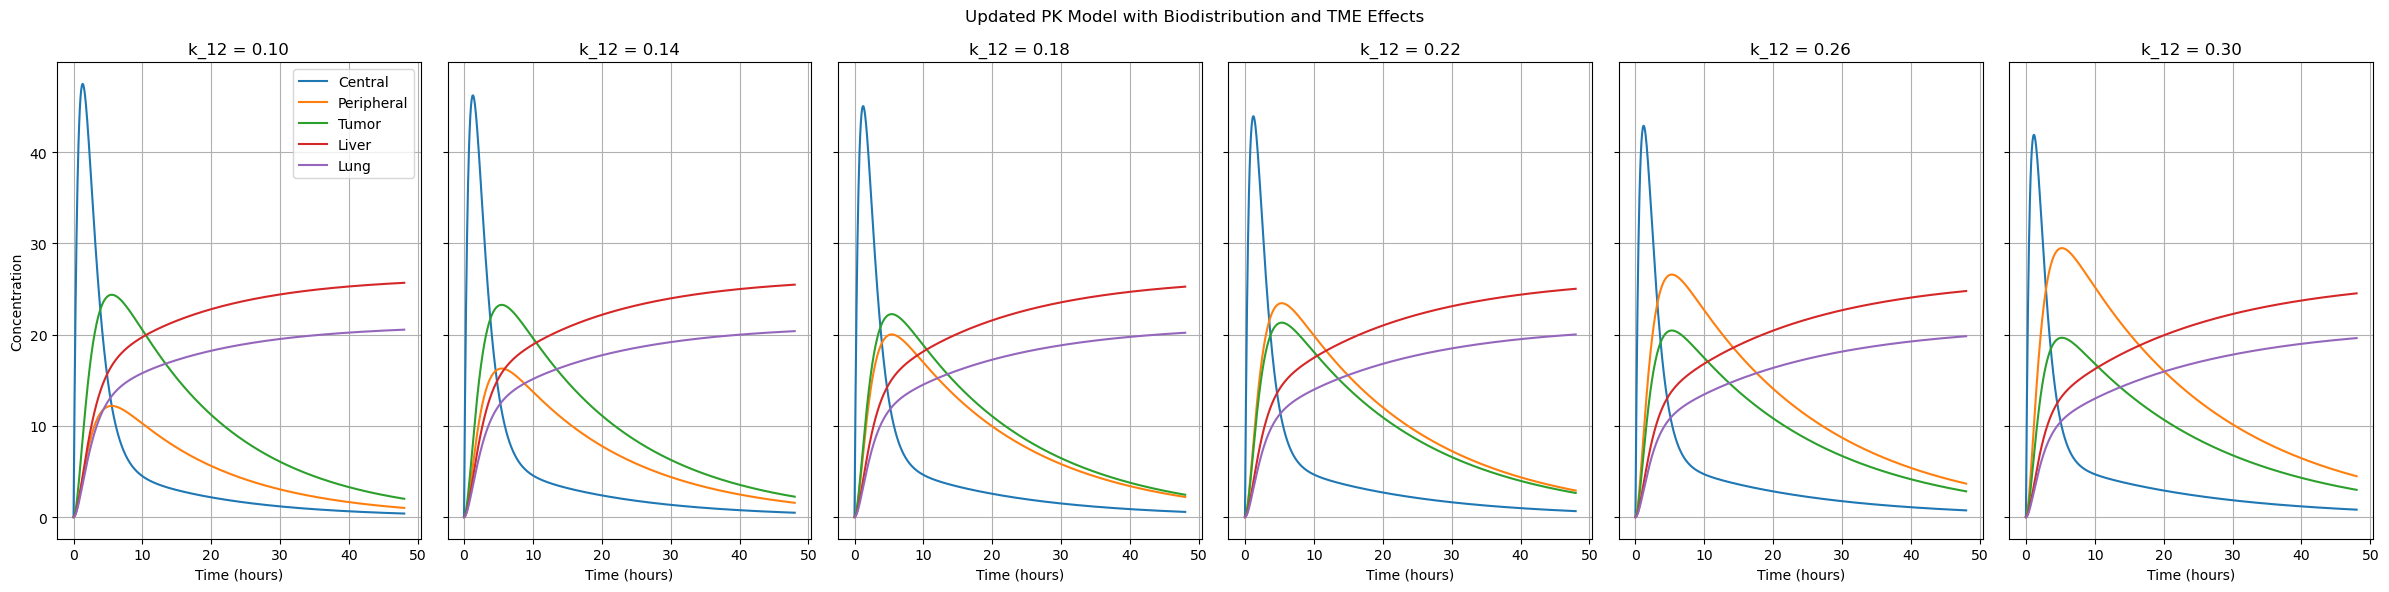

In [8]:
# test now for k_12
# Time points for simulation
t = np.linspace(0, 48, 1000)  # Simulate over 48 hours with fine resolution

# Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
# Tumor Compartment, Liver Compartment, Lung Compartment]
y0_updated = [dose, 0, 0, 0, 0, 0]

num_sweeps = len(parameter_sweep['k_12'])
fig, axes = plt.subplots(1, num_sweeps, figsize=(num_sweeps * 4, 6), sharey=True)

for i, k_12 in enumerate(parameter_sweep['k_12']):
    solution_updated = odeint(pk_model_updated, y0_updated, t,
                              args=(k_a, k_12, k_21, k_e, k_tumor, k_out_tumor,
                                    k_liver, k_lung, k_tme))

    ax = axes[i] if num_sweeps > 1 else axes
    ax.plot(t, solution_updated[:, 1], label='Central')
    ax.plot(t, solution_updated[:, 2], label='Peripheral')
    ax.plot(t, solution_updated[:, 3], label='Tumor')
    ax.plot(t, solution_updated[:, 4], label='Liver')
    ax.plot(t, solution_updated[:, 5], label='Lung')

    ax.set_xlabel('Time (hours)')
    ax.set_title(f'k_12 = {k_12:.2f}')
    ax.grid(True)

axes[0].set_ylabel('Concentration')
axes[0].legend()

plt.suptitle('Updated PK Model with Biodistribution and TME Effects')
plt.tight_layout()
plt.show()

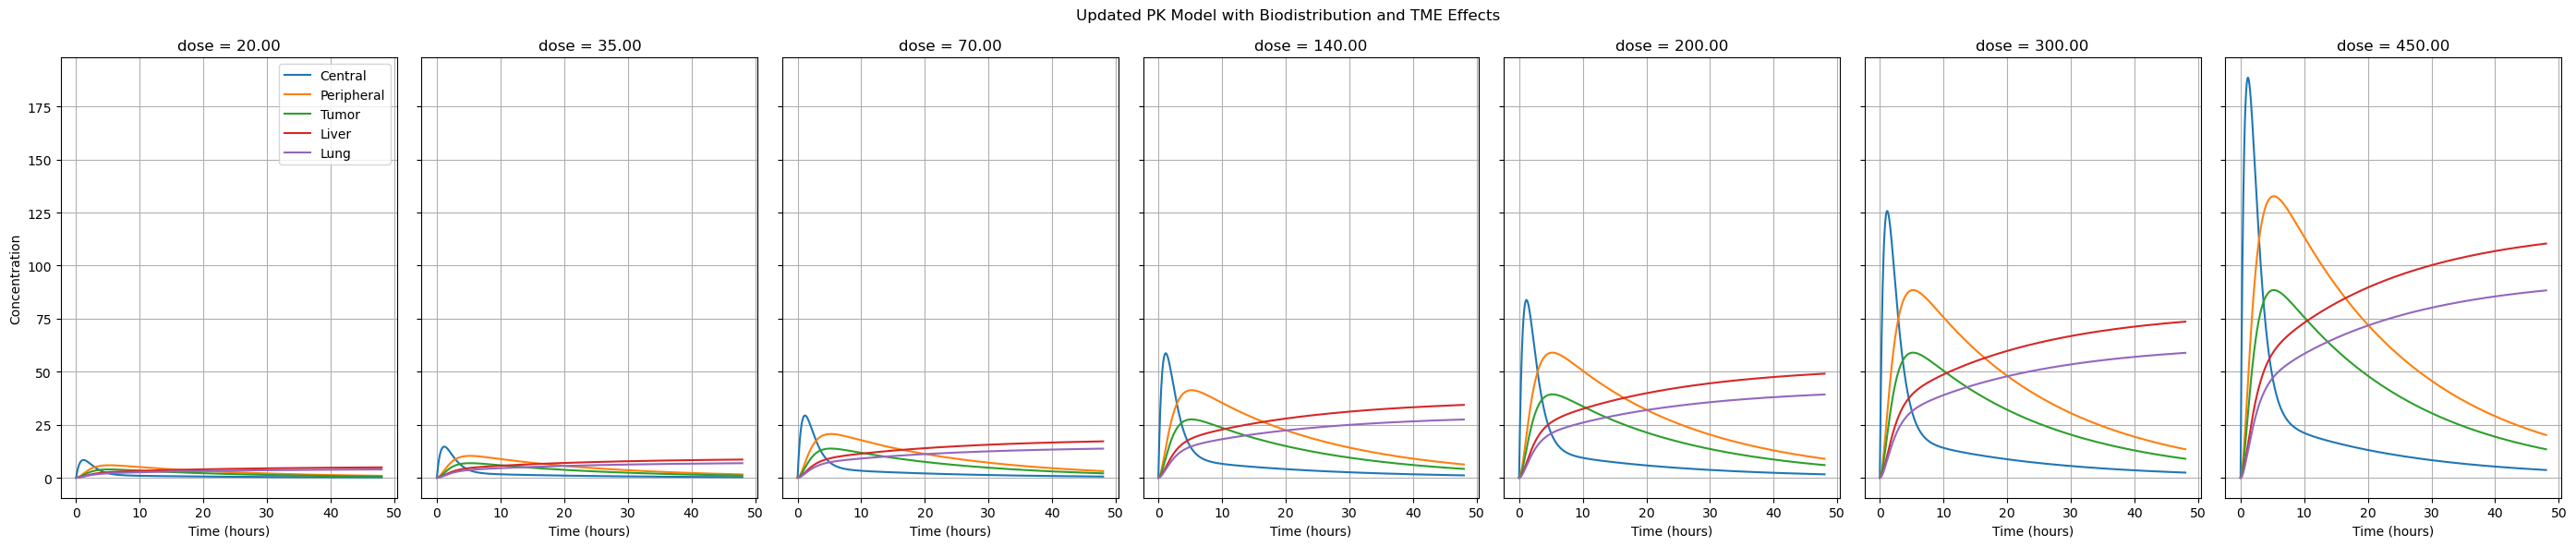

In [15]:
# test now for DOSE
# Time points for simulation
t = np.linspace(0, 48, 1000)  # Simulate over 48 hours with fine resolution

# Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
# Tumor Compartment, Liver Compartment, Lung Compartment]

num_sweeps = len(parameter_sweep['dose'])
fig, axes = plt.subplots(1, num_sweeps, figsize=(num_sweeps * 4, 6), sharey=True)

for i, dose in enumerate(parameter_sweep['dose']):
    y0_updated = [dose, 0, 0, 0, 0, 0]
    solution_updated = odeint(pk_model_updated, y0_updated, t,
                              args=(k_a, k_12, k_21, k_e, k_tumor, k_out_tumor,
                                    k_liver, k_lung, k_tme))

    ax = axes[i] if num_sweeps > 1 else axes
    ax.plot(t, solution_updated[:, 1], label='Central')
    ax.plot(t, solution_updated[:, 2], label='Peripheral')
    ax.plot(t, solution_updated[:, 3], label='Tumor')
    ax.plot(t, solution_updated[:, 4], label='Liver')
    ax.plot(t, solution_updated[:, 5], label='Lung')

    ax.set_xlabel('Time (hours)')
    ax.set_title(f'dose = {dose:.2f}')
    ax.grid(True)

axes[0].set_ylabel('Concentration')
axes[0].legend()

plt.suptitle('Updated PK Model with Biodistribution and TME Effects')
plt.tight_layout()
plt.show()

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define sweep parameters (only those that vary)
sweep_params = {key: val for key, val in parameter_sweep.items() if isinstance(val, np.ndarray)}

# Create all combinations of parameter values
param_combinations = list(itertools.product(*sweep_params.values()))

num_combos = len(param_combinations)
fig, axes = plt.subplots(len(sweep_params), len(param_combinations) // len(sweep_params), 
                         figsize=(15, 3 * len(sweep_params)), sharey=True, sharex=True)

# Iterate over parameter combinations
for idx, param_vals in enumerate(param_combinations):
    params = dict(zip(sweep_params.keys(), param_vals))  # Assign values to corresponding parameters
    
    # Solve ODE with the current set of parameters
    solution = odeint(pk_model_updated, y0_updated, t,
                      args=(params['k_a'], params['k_12'], params['k_21'], params['k_e'], 
                            params['k_tumor'], params['k_out_tumor'], params['k_liver'], 
                            params['k_lung'], params['k_tme']))
    
    row = idx % len(sweep_params)  # Row corresponds to the parameter being varied
    col = idx // len(sweep_params)  # Column corresponds to the different values of that parameter
    ax = axes[row, col] if len(sweep_params) > 1 else axes[col]
    
    # Plot each compartment
    ax.plot(t, solution[:, 1], label='Central')
    ax.plot(t, solution[:, 2], label='Peripheral')
    ax.plot(t, solution[:, 3], label='Tumor')
    ax.plot(t, solution[:, 4], label='Liver')
    ax.plot(t, solution[:, 5], label='Lung')

    ax.set_title(f"{list(sweep_params.keys())[row]} = {param_vals[row]:.2f}")
    ax.grid(True)

# Label first column and row properly
axes[0, 0].set_ylabel('Concentration')
axes[-1, 0].set_xlabel('Time (hours)')
axes[0, 0].legend()

plt.suptitle("Impact of Parameter Sweeps on PK Model", fontsize=16)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

## Efficacy analysis

In [ ]:
# Quantify Tumor Penetration and Efficacy

# Define efficacy threshold for tumor compartment concentration
efficacy_threshold = 10.0

# Calculate Area Under the Curve (AUC) for tumor compartment
def calculate_auc(concentration, time):
    return np.trapz(concentration, time)

auc_tumor = calculate_auc(solution_updated[:, 3], t)

# Check if efficacy threshold is met
efficacy_met = np.max(solution_updated[:, 3]) >= efficacy_threshold

print(f"AUC in Tumor Compartment: {auc_tumor:.2f}")
print(f"Efficacy Threshold Met: {'Yes' if efficacy_met else 'No'}")

# Sensitivity Analysis

# Define a function to run the model and calculate AUC for tumor compartment
def run_model_and_calculate_auc(k_tumor_val):
    solution_sa = odeint(pk_model_updated, y0_updated,
                         t,
                         args=(k_a,
                               k_12,
                               k_21,
                               k_e,
                               k_tumor_val,
                               k_out_tumor,
                               k_liver,
                               k_lung,
                               k_tme))
    auc_sa = calculate_auc(solution_sa[:, 3], t)
    return auc_sa

# Perform sensitivity analysis on tumor homing parameter (k_tumor)
k_tumor_values = np.linspace(0.1, 0.5, num=5)   # Test values for sensitivity analysis
auc_results = [run_model_and_calculate_auc(k) for k in k_tumor_values]

# Plot sensitivity analysis results
plt.figure(figsize=(10, 6))
plt.plot(k_tumor_values, auc_results)
plt.xlabel('Tumor Homing Rate Constant (k_tumor)')
plt.ylabel('AUC in Tumor Compartment')
plt.title('Sensitivity Analysis: Effect of Tumor Homing on AUC')
plt.grid(True)
plt.show()

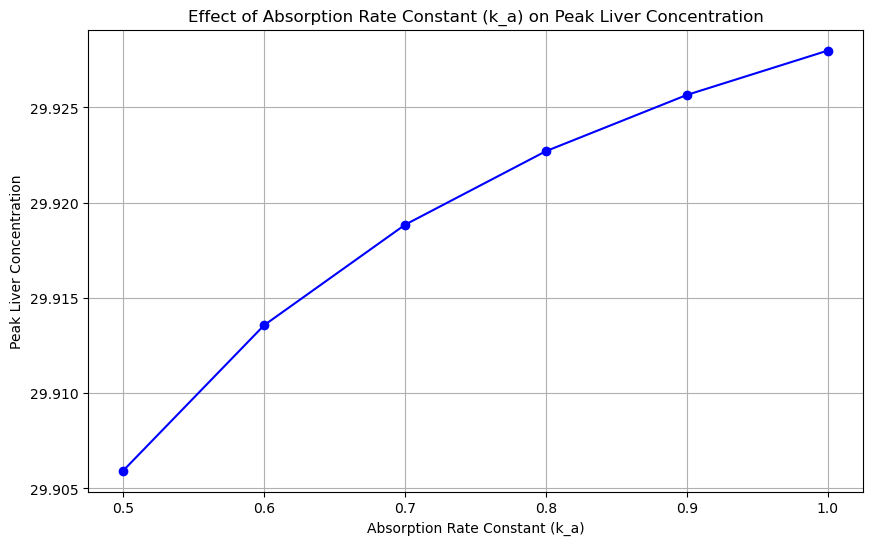

In [8]:
# Define a function to calculate the peak liver concentration for a given k_a
def calculate_peak_liver_concentration(k_a_val):
    solution = odeint(pk_model_updated, y0_updated, t,
                      args=(k_a_val, k_12, k_21, k_e, k_tumor, k_out_tumor,
                            k_liver, k_lung, k_tme))
    peak_liver_concentration = np.max(solution[:, 4])  # Liver compartment is index 4
    return peak_liver_concentration

# Perform the analysis for varying k_a values
k_a_values = parameter_sweep['k_a']
peak_liver_concentrations = [calculate_peak_liver_concentration(k) for k in k_a_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_a_values, peak_liver_concentrations, marker='o', linestyle='-', color='b')
plt.xlabel('Absorption Rate Constant (k_a)')
plt.ylabel('Peak Liver Concentration')
plt.title('Effect of Absorption Rate Constant (k_a) on Peak Liver Concentration')
plt.grid(True)
plt.show()